# Real-time exposure monitoring (rtxm)
<h3>An R pseudo-package for fitting real-time exposure models</h3>

This pseudo-package provides software for the class of models described in [Houseman and Virji (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5712446/), *A Bayesian Approach for Summarizing and Modeling Time-Series Exposure Data with Left Censoring*.

In particular, the software fits the following model:

\begin{equation}
Y_{ir} = \alpha (task_{ir}) + \mathbf{\mathrm{x}}_{ir}^t \mathbf{\beta}+f_{i}(time_{ir})+\varepsilon_{ir}
\end{equation}

where $i$ indexes a subject (e.g. an employee), $r$ indexes a sequential measurement within the profile corresponding to subject $i$, $Y_{ir}$ is the measured value (or its logarithm), measured at time $time_{ir}$, $\alpha (task_{ir})$ is the conditional mean of the task being performed at $time_{ir}$ (one of a set of finite tasks), $f_{i}(t)$ is a subject-specific trajectory accounting for nonstationary temporal autocorrelation across the time period, and $\varepsilon_{ir}$ is a additional error term whose variance depends on the task being performed (i.e. $task_{ir}$). Note that $Y_{ir}$ may be left-censored (i.e. subject to detection limits).  In this model, $f_{i}(t)$ is realized using an appropriately regularized B-spline representation.  See the published paper for details.

The method has been used in [Virji, Liang et al. (2019)](https://academic.oup.com/annweh/advance-article-pdf/doi/10.1093/annweh/wxz043/28761303/wxz043.pdf), *Peaks, Means, and Determinants of Real-Time TVOC Exposures Associated with Cleaning and Disinfecting Tasks in Healthcare Settings*.

A release of the current version can be found [here](https://github.com/eahouseman/rtxm).  In particular, the read-me for the current release can be found [here](https://github.com/eahouseman/rtxm/blob/master/README.md).  
This notebook demonstrates in detail Example 4 of the release.

In [1]:
#####################################################################
# EXAMPLE 4 (2017 March 7)
#
# This demonstrates the basic model (nondetects, covariates)
#####################################################################

# Change working directory to an appropriate location
setwd('C:\\Users\\eahou\\Documents\\Virji\\rtxm')

source("rtxm.R") # Load the package

Warning message:
"package 'rjags' was built under R version 3.6.1"Loading required package: coda
Warning message:
"package 'coda' was built under R version 3.6.1"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [2]:
###################################################
# Read data
load("rtxmSampleData.RData")
theData <- sample_data

###################################################
#  Get time data and create "time/employee" profiles
#    Note:  to understand the second argument, 
#           see help for base function "strptime"
theDataDateTime <- rtxmParseDateTime(theData$DateTime, "%d%b%Y:%H:%M:%S")
head(theDataDateTime)

# Concatenated location / sample date 
#  (will function as a "profile" for this example)
theData$Profile <- paste(theData$Location, theDataDateTime$date, sep=":")
print(head(theData$Profile))

date,day.year,day.month,day.monthDay,day.yearDay,time.days
2016-3-15,2016,2,15,74,0.4046181
2016-3-15,2016,2,15,74,0.4067014
2016-3-15,2016,2,15,74,0.4087847
2016-3-15,2016,2,15,74,0.4108681
2016-3-15,2016,2,15,74,0.4129514
2016-3-15,2016,2,15,74,0.4150347


[1] "Location2:2016-3-15" "Location2:2016-3-15" "Location2:2016-3-15"
[4] "Location2:2016-3-15" "Location2:2016-3-15" "Location2:2016-3-15"


In [3]:
###################################################
# Fix duplicates

# These are possile duplicates, as judged by their having the same
#  time stamp and reading values
possDups <- rtxmFindDuplicates(theData$lnY, theData$Profile, theDataDateTime$time.days)
print(possDups)

# Remove duplicates (would fix if there were duplicates)
theData <- rtxmFixDuplicates(possDups, theData)

###################################################
#  Create spline basis
#  (B-spline basis with knots based on quantiles obtained by
#    attempting to place 8 knots per hour in the support of the time distribution)
theSplineBasis <- rtxmMakeBspline(theDataDateTime$time.days, 8)

###################################################
#  Fake non-detect data
MY.LOD <- log(25)
theData$lnYND <- pmax(MY.LOD, theData$lnY)


list()


Warning message in rtxmFixDuplicates(possDups, theData):
"There are no duplicates to fix!"

In [4]:
###################################################
#  Create model object
myModel <- rtxmBasicLODCovariatesModel(
  ~lnYND,                                 # Response (Y) 
  ~TaskID,                                # Task (factor variable)
  theSplineBasis,                         # Spline basis object (see above)
  LOD=MY.LOD,                             # LOD (on same scale as Y)
  zCovariates=~Source_enclosure+Volume,   # Covariate model
  data=theData,                           # Data set to interpret variables
  gGroup=~Profile                         # Series (profile) identifier
)

# Burn-in samples
update(myModel,500)  # Adaptation
update(myModel,5000)  # Burn-in

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 158
   Unobserved stochastic nodes: 212
   Total graph size: 13353

Initializing model

500 TRUE 


In [5]:
# Print the model object
print(myModel)

Basic Model for real-time exposure monitoring
(Nondetects, covariates) 

Observations: 168 
Tasks: 5 
Profiles: 3 

Hyperparameters:
 BETAPRECISION BETA0PRECISION    XIPRECISION 
         1e-04          1e-04          1e-04 

Spline basis functions: 63 
Spline boundary: 0 1 
Knots: n=60, density in support: 8 per hour

Limit-of-detection: 3.218876 
Percent non-detect: 6 

Local file containing model definition: C:\Users\eahou\AppData\Local\Temp\RtmpaorM1j\file43283f4a2347 

Markov-Chain Monte-Carlo status: adapted/burn-in 
Markov-Chain Monte-Carlo burn-in: 5000 


In [6]:
# Show the underlying JAGS model
showJAGS(myModel)

model{
        tauZ ~ dnorm(0,1.0E-6)T(0,1.0E10)

        beta0 ~ dnorm(0,BETA0PRECISION)

        for(it in 1:Nprofile){
          for(j in 1:D){
            zeta[it,j] ~ dnorm(0, tauZ)
          }
        }

        for(h in 1:Nsample){
          muTimedep[h] <- inprod(spline[h,1:D],zeta[idProfile[h],1:D])
          muExtra[h] <- inprod(covariates[h,1:nCovariates], xi[1:nCovariates])
          muTask[h] <-  beta0 + inprod(task[h,1:P],beta[1:P])
          mu[h] <-  muTimedep[h] + muTask[h] + muExtra[h]
        }

        for(g1 in 1:NDetect){
          yDetect[g1] ~ dnorm(mu[detectIndex[g1]], tauE[idTask[detectIndex[g1]]])
        }

        for(g0 in 1:NnonDetect){
          yNonDetect[g0] ~ dnorm(mu[nonDetectIndex[g0]], tauE[idTask[nonDetectIndex[g0]]])
          isDetectND[g0] ~ dinterval(yNonDetect[g0] , DETECTLIMIT)
        }

        for(l in 1:P){
          beta[l] ~ dnorm(0,BETAPRECISION)
        }

        for(r in 1:nCovariates){
          xi[r] ~ dnorm(0,XIPRECISION)
      

In [7]:
###################################################
#  Collect MCMC samples

update(myModel,100,"$standard",10) # Test run with 100
myModel

update(myModel,5000,"$standard",10) # 10000 samples thinned by 10
myModel

NOTE: Stopping adaptation




Basic Model for real-time exposure monitoring
(Nondetects, covariates) 

Observations: 168 
Tasks: 5 
Profiles: 3 

Hyperparameters:
 BETAPRECISION BETA0PRECISION    XIPRECISION 
         1e-04          1e-04          1e-04 

Spline basis functions: 63 
Spline boundary: 0 1 
Knots: n=60, density in support: 8 per hour

Limit-of-detection: 3.218876 
Percent non-detect: 6 

Local file containing model definition: C:\Users\eahou\AppData\Local\Temp\RtmpaorM1j\file43283f4a2347 

Markov-Chain Monte-Carlo status: sampling block 1 
Markov-Chain Monte-Carlo burn-in: 5000 

Sample history:
    N thin                    variables
1 100   10 beta,beta0,tauE,tauZ,xi,zeta

Basic Model for real-time exposure monitoring
(Nondetects, covariates) 

Observations: 168 
Tasks: 5 
Profiles: 3 

Hyperparameters:
 BETAPRECISION BETA0PRECISION    XIPRECISION 
         1e-04          1e-04          1e-04 

Spline basis functions: 63 
Spline boundary: 0 1 
Knots: n=60, density in support: 8 per hour

Limit-of-detection: 3.218876 
Percent non-detect: 6 

Local file containing model definition: C:\Users\eahou\AppData\Local\Temp\RtmpaorM1j\file43283f4a2347 

Markov-Chain Monte-Carlo status: sampling block 2 
Markov-Chain Monte-Carlo burn-in: 5000 

Sample history:
     N thin                    variables
1  100   10 beta,beta0,tauE,tauZ,xi,zeta
2 5000   10 beta,beta0,tauE,tauZ,xi,zeta

In [8]:
###################################################
# Output and graphics
summary(myModel)  # Model summary

$`fixed effects`
                          mean          sd        2.5%        50%      97.5%
(Intercept)         11.1826422 0.256158767 10.71047875 11.2318950 11.5742230
Task2                2.0326998 0.220702033  1.63551220  2.0408167  2.4334899
Task3                2.2281989 0.233585340  1.77339195  2.2348270  2.6521302
Task4                0.1013222 0.084183749 -0.07169869  0.1024320  0.2591190
Task5                5.1498826 0.502455581  4.24711477  5.1802415  5.9504325
Source_enclosureYes  0.2395350 0.206022153 -0.14637220  0.2641534  0.6212132
Volume              -0.1778946 0.008511445 -0.18988584 -0.1808643 -0.1626548

$`task standard deviations`
            2.5%        50%     97.5%
Task1 0.07410471 0.12018215 0.2138235
Task2 0.11473980 0.13275236 0.1555984
Task3 0.02027495 0.03882894 0.1627891
Task4 0.04362924 0.07602679 0.1448588
Task5 0.05470045 0.08432004 0.1543180

$`zeta standard deviation`
     2.5%       50%     97.5% 
0.3052058 0.3793792 0.4714839

In [9]:
####################
# Predictions
myPredictions <- predict(myModel)

dim(myPredictions)
head(myPredictions)

[1] 168   5

mean,sd,2.5%,50%,97.5%
4.455079,0.05126744,4.350186,4.461574,4.534341
4.315704,0.05381493,4.245161,4.306416,4.445365
4.478592,0.05215804,4.417525,4.467299,4.606551
4.804606,0.04331328,4.716451,4.803344,4.884847
5.125528,0.06924330,4.957508,5.140679,5.208701
5.507371,0.06519093,5.371556,5.511963,5.630399


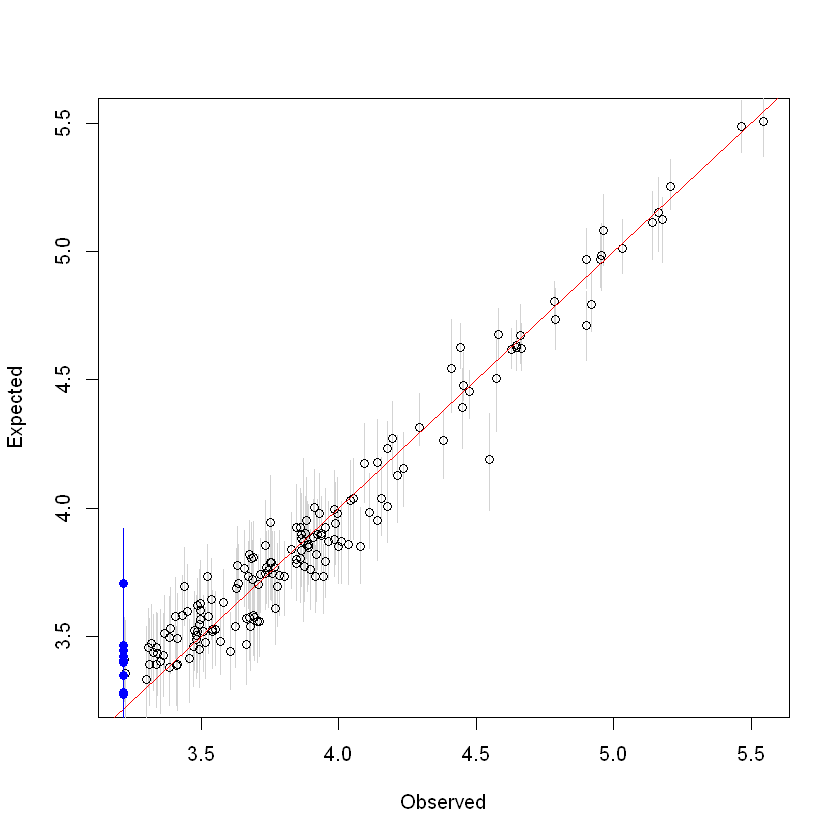

In [10]:
####################
# Prediction plot
plot(myModel, what=".obsvpred")

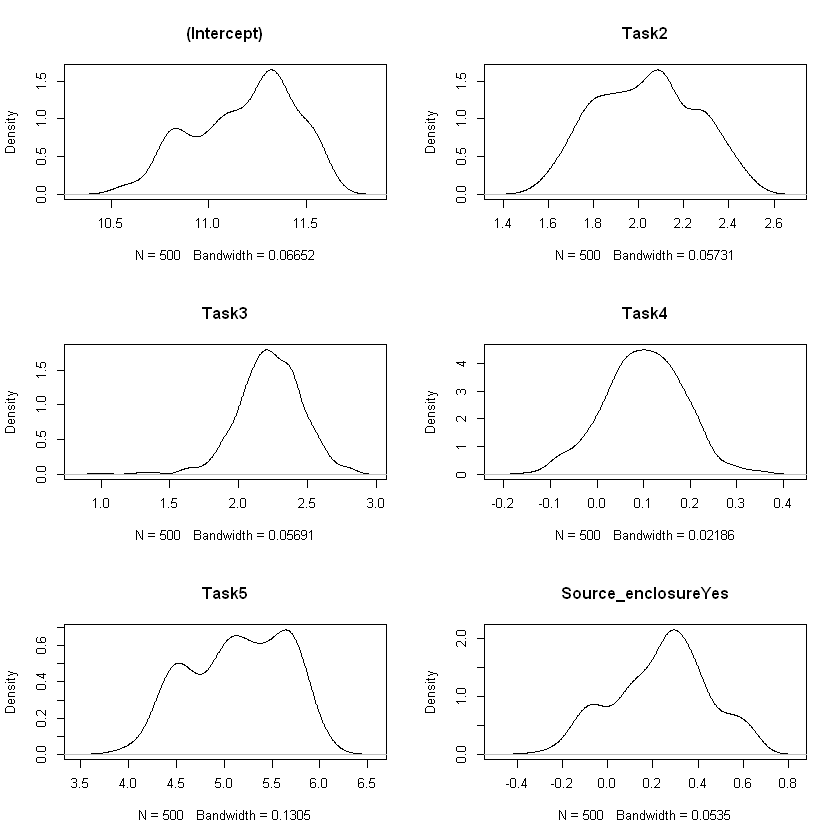

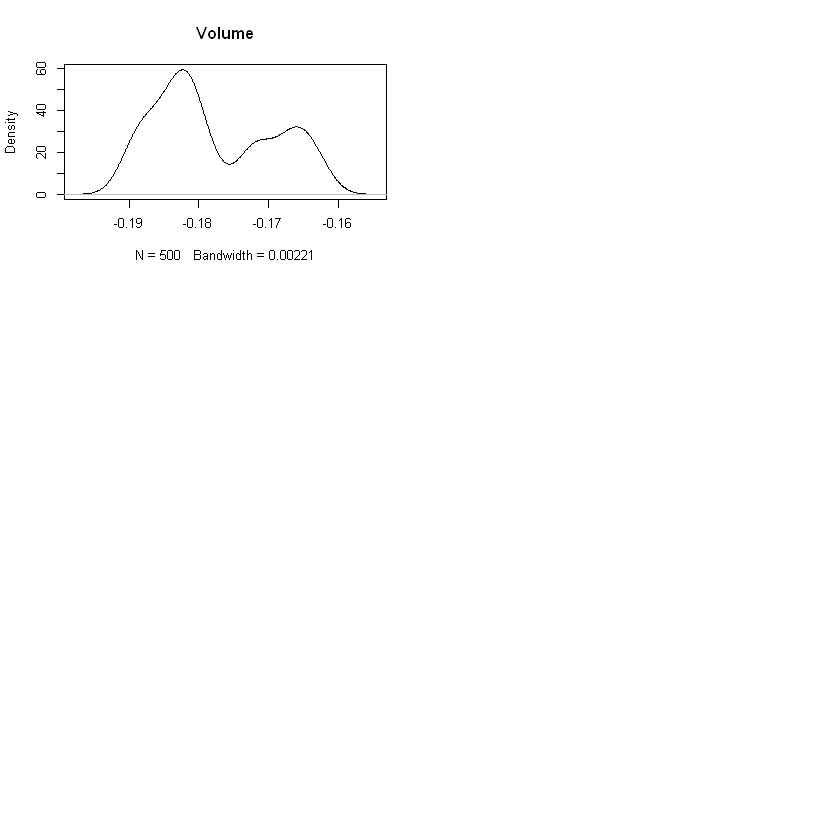

In [11]:
####################
# Density plots

# Fixed-effects coefficients
plot(myModel, what=".density.coefs", panels=c(3,2))

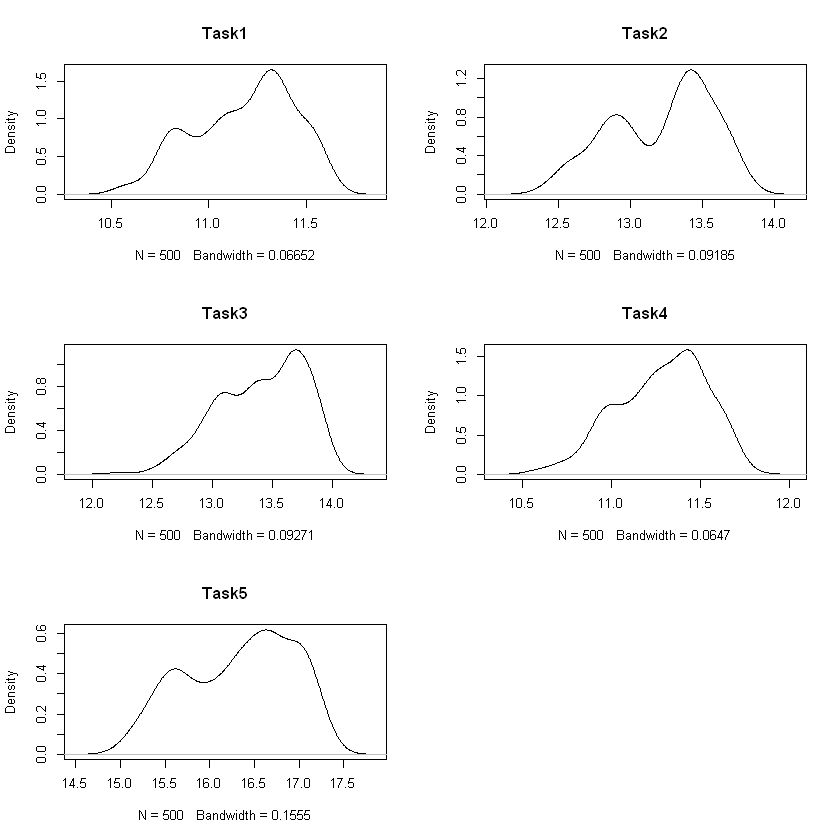

In [12]:
# Task-specific means
plot(myModel, what=".density.tasks", panels=c(3,2))

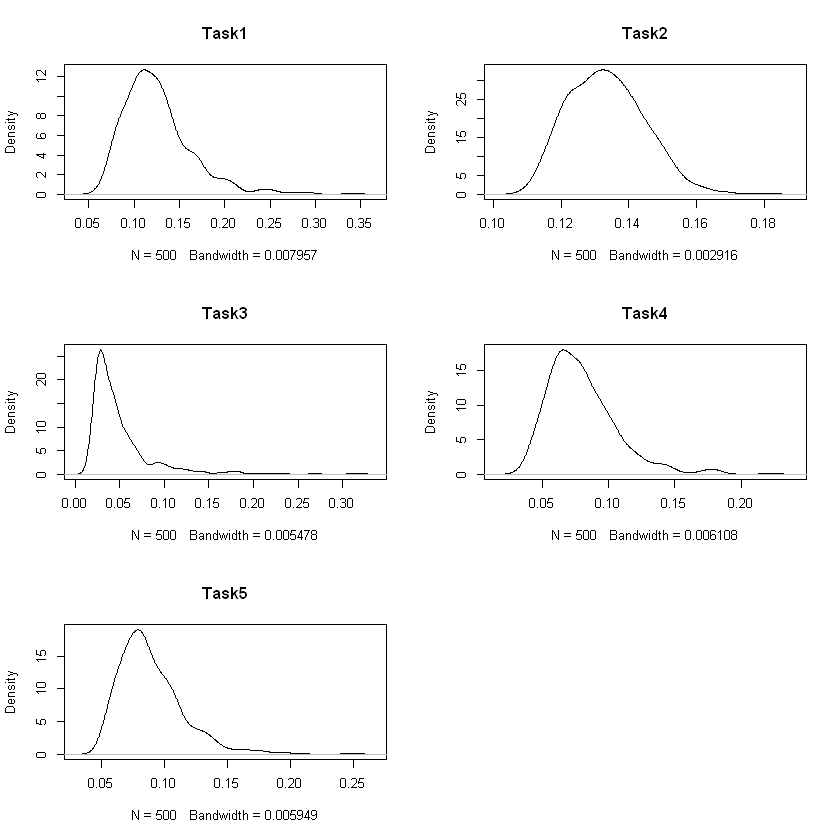

In [13]:
# Task-specific standard deviations
plot(myModel, what=".density.sdEpsilon", panels=c(3,2))

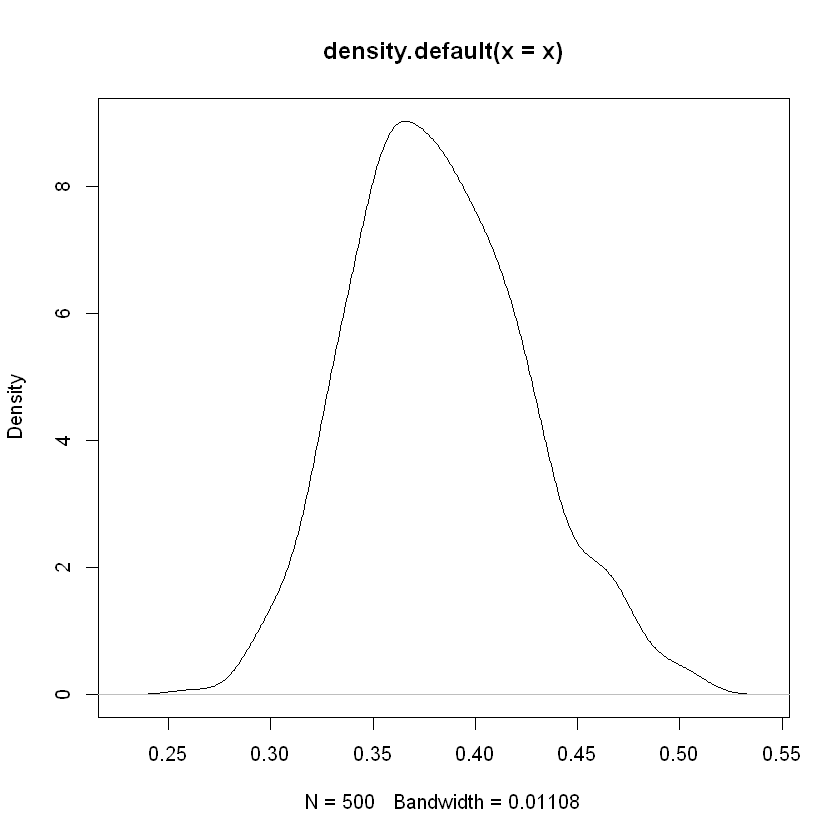

In [14]:
# Standard deviation of the spline coefficients
plot(myModel, what=".density.sdZeta")

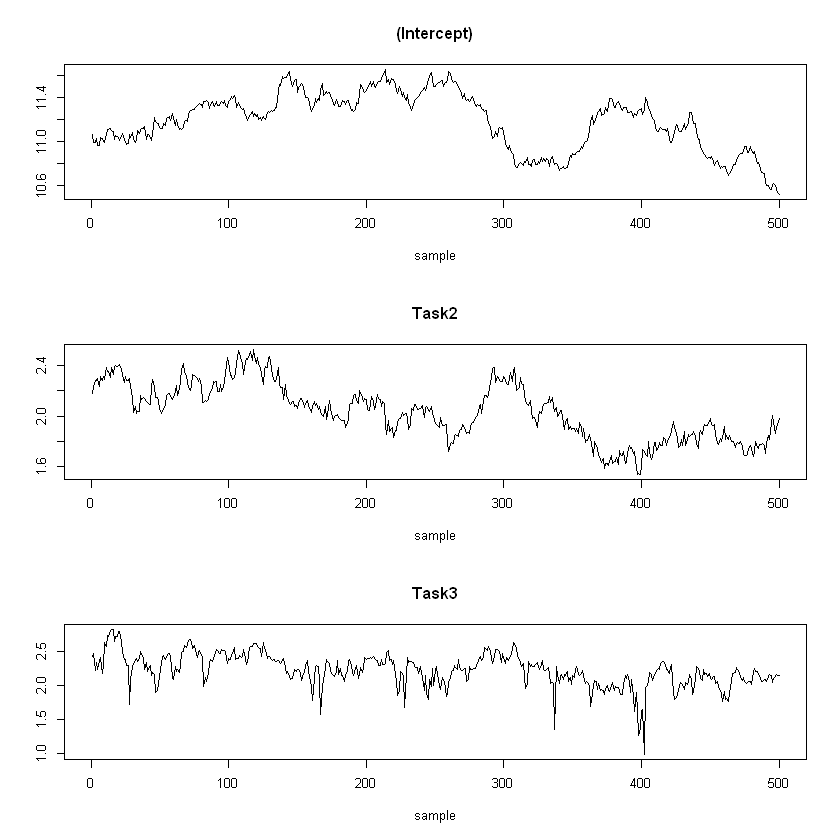

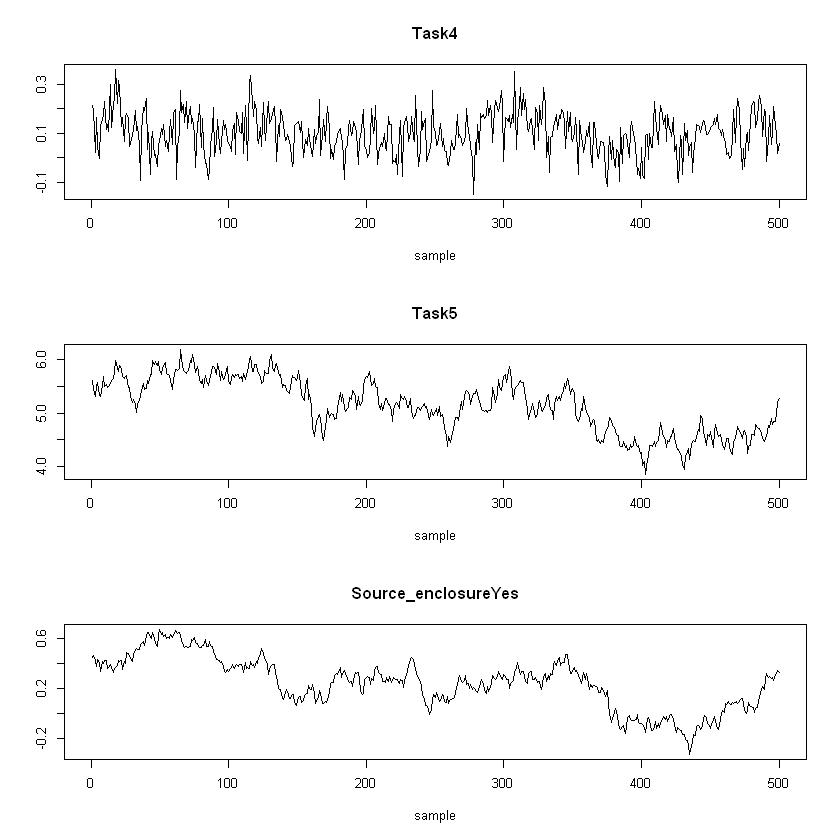

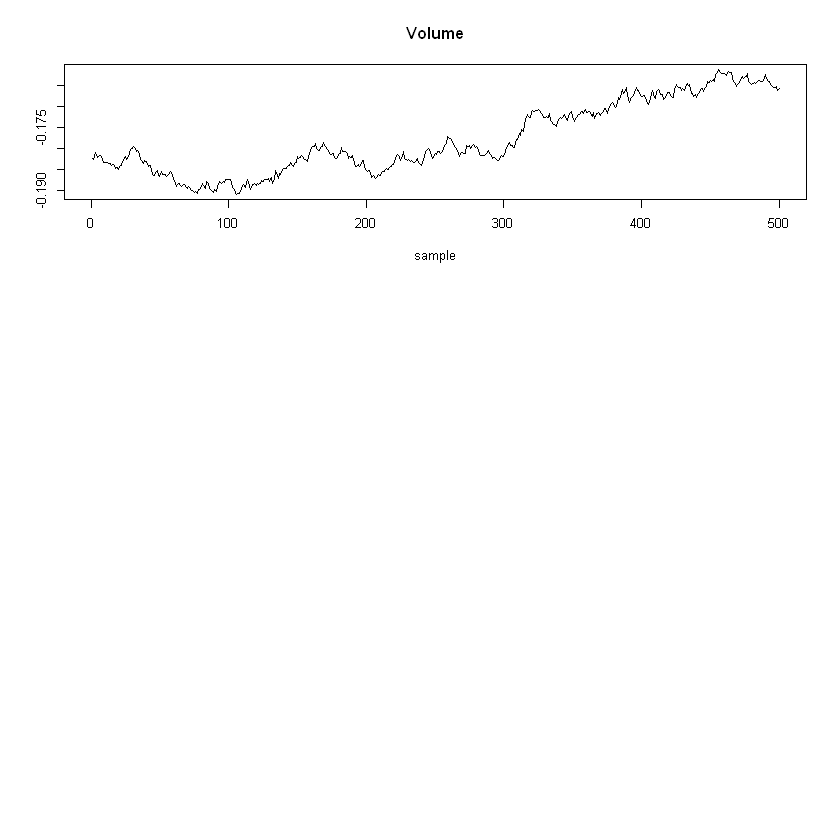

In [15]:
####################
# Trace plots
plot(myModel, what=".trace.coefs")

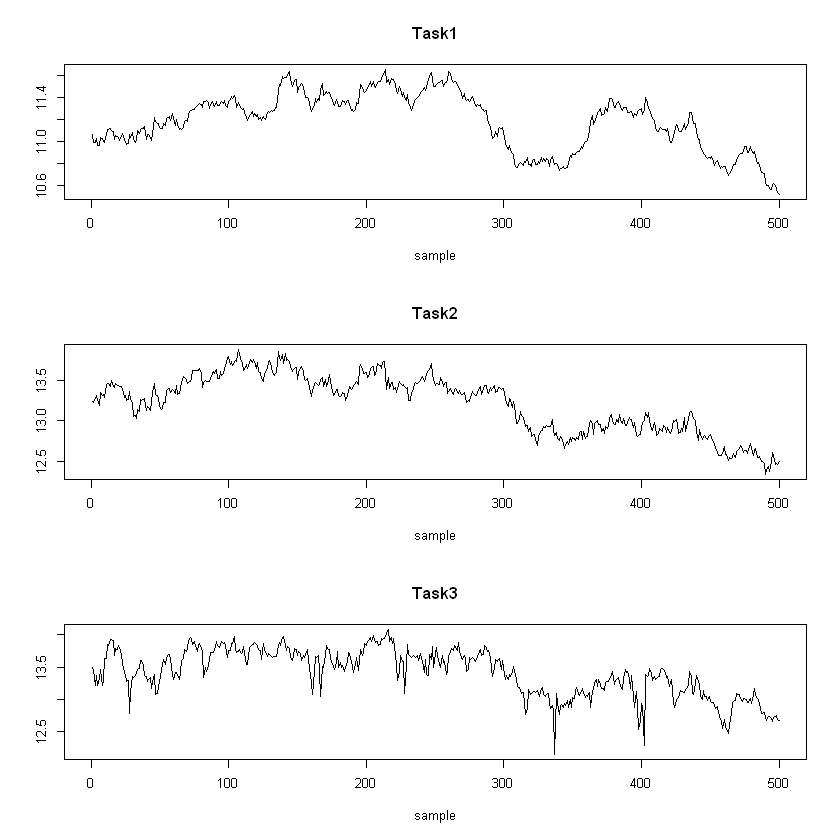

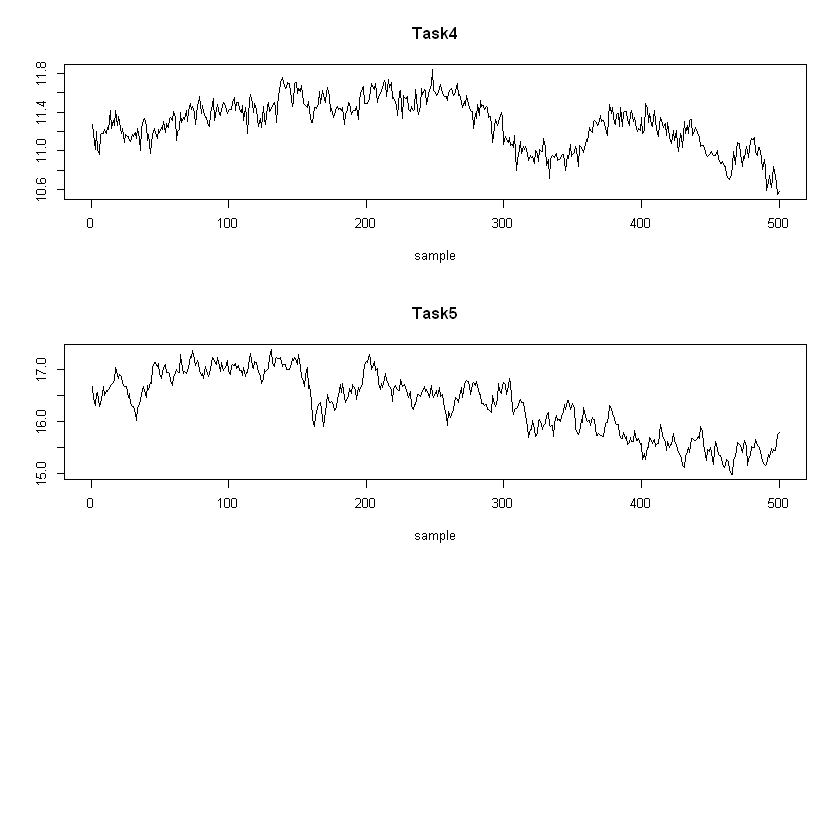

In [16]:
plot(myModel, what=".trace.tasks")

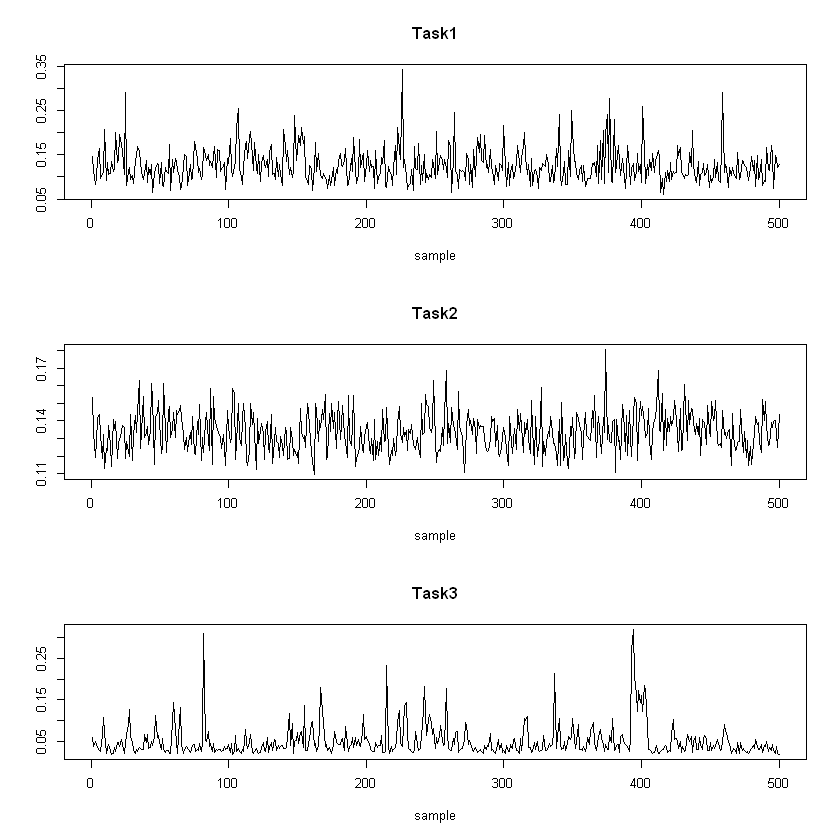

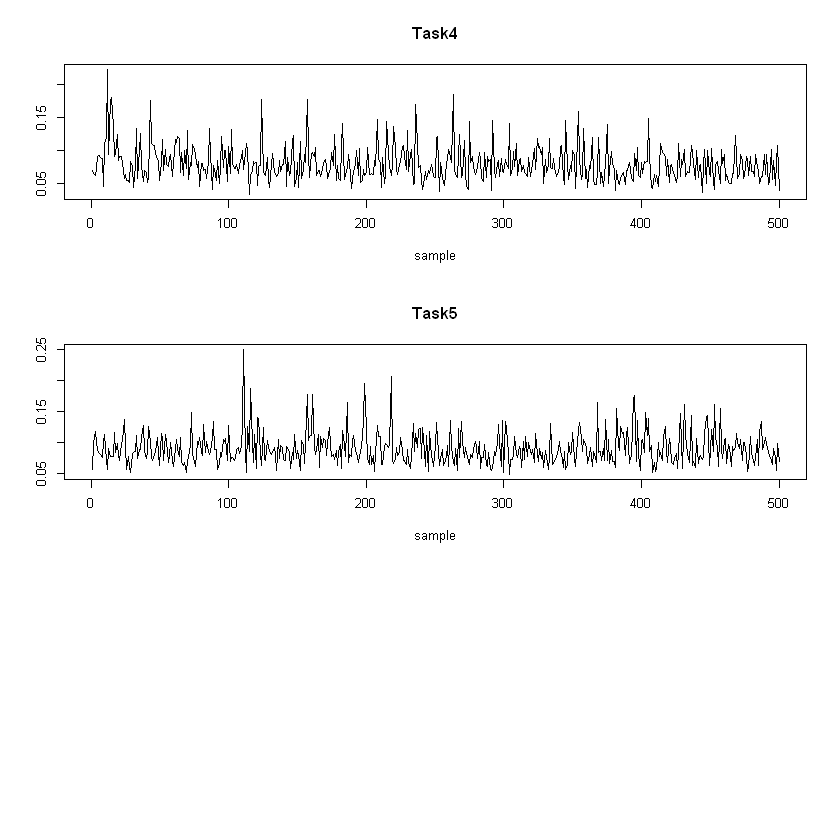

In [17]:
plot(myModel, what=".trace.sdEpsilon")

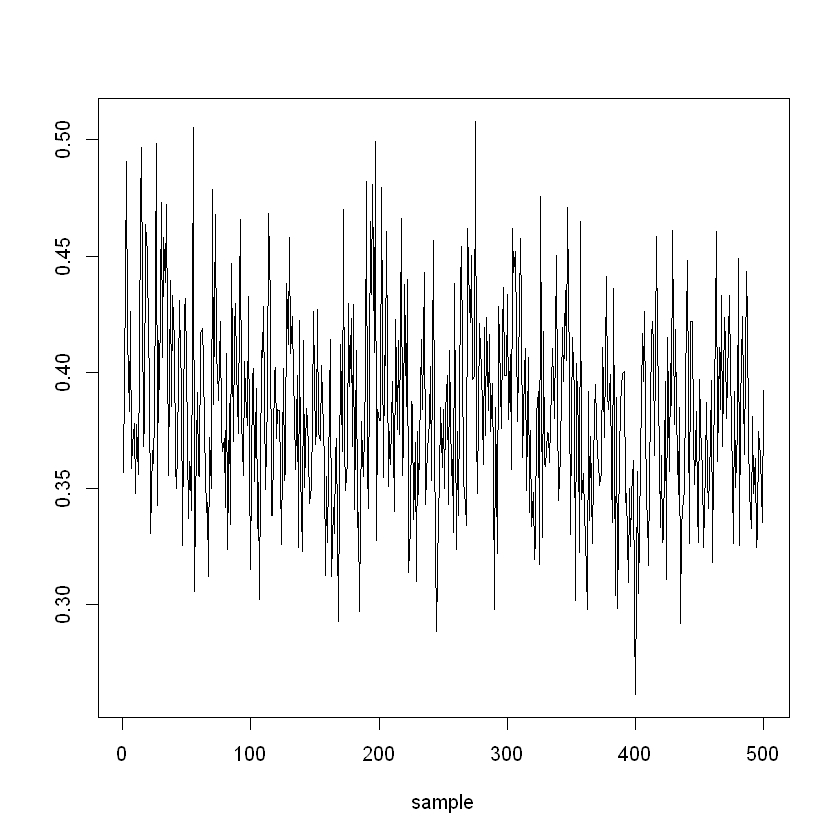

In [18]:
plot(myModel, what=".trace.sdZeta")